# Detecting Fraud in eCommerce Transactions
 
(Data: https://www.kaggle.com/c/ieee-fraud-detection/data)

In this project, I predict the probability that an eCommerce transaction is fraudulent. I analyze data, engineer features, and compare several classifiers to select and tune the best model. 

The goal is to improve the efficacy of fraudulent transaction alerts, helping businesses reduce their fraud loss and improve customer satisfaction.

Topics:

- Exploratory Data Analysis
- Feature Engineering (including Principal Component Analysis (PCA))
- Class imbalance techniques (Random Undersampling, Synthetic Minority Oversampling Technique (SMOTE))
- Model selection and tuning (Logistic Regression, Decision Tree, Gradient Boosting Classifier, Random Forest Classifier, GridSearchCV)
- Model evaluation (Area under Receiver Operating Characteristics curve (ROC AUC))

## Summary Findings
After analyzing the data and comparing models, I trained a gradient boosting classifier with ROC AUC=0.94. There is a 94% chance that this model will be able to distinguish between fraudulent and normal transactions.

For more details, please refer to the analysis below.

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats.stats import ttest_ind

import re

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn import tree, ensemble, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
import pydotplus
import graphviz

from collections import Counter
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('darkgrid')

Using TensorFlow backend.


## Exploratory Data Analysis and Feature Engineering

The data is broken into two files, "identity" and "transaction." Not all transactions have corresponding identity information. I'll merge the files, conduct univariate and multivariate analysis, and engineer features.

In [2]:
# Read in the data.
df_train_identity = pd.read_csv('train_identity.csv')
df_train_transaction = pd.read_csv('train_transaction.csv')

In [3]:
# Quick review of the data.
print(df_train_transaction.shape)
df_train_transaction.head()

(590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print(df_train_identity.shape)
df_train_identity.head()

(144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
# Merge transaction and identity train data.
df_train = pd.merge(df_train_transaction, df_train_identity,
                    how='left', on='TransactionID')
del df_train_identity, df_train_transaction

# Review the data.
print(df_train.shape)

(590540, 434)


In [6]:
# # Get percentage of missing values.
# df_null = (df_train.isnull().sum()*100/df_train.isnull().count())
# df_null.sort_values(ascending=False)

In [7]:
# Impute missing data in categorical variables.
for i in df_train.columns:
    if df_train[i].dtype==object:
        df_train[i] = df_train[i].fillna('missing')

In [8]:
# Review data.
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Target Variable

"isFraud" is a binary variable, so I'll work with classification models. 

The distribution of the classes shows that 3.6% of transactions are labeled as a fraud, and 96.4% of transactions are labeled as normal. Later in the process, I'll use techniques to even out the volume of observations in each class.

In [9]:
# Get percentage of fraudulent transactions.
print(df_train['isFraud'].value_counts())
df_train['isFraud'].value_counts()[1]*100/df_train['isFraud'].value_counts()[0]

0    569877
1     20663
Name: isFraud, dtype: int64


3.625870143908247

Text(0.5, 1.0, 'Normal vs. Fraudulent Transactions')

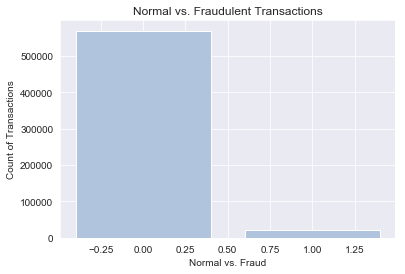

In [10]:
# Plot normal vs. fraudulent transactions:
plt.bar(df_train.groupby('isFraud')['isFraud'].count().index,
         df_train.groupby('isFraud')['isFraud'].count(), color='lightsteelblue')
plt.ylabel('Count of Transactions')
plt.xlabel('Normal vs. Fraud')
plt.title('Normal vs. Fraudulent Transactions')

### Transaction Time Delta
TransactionDT is "timedelta from a given reference datetime (not an actual timestamp)." 

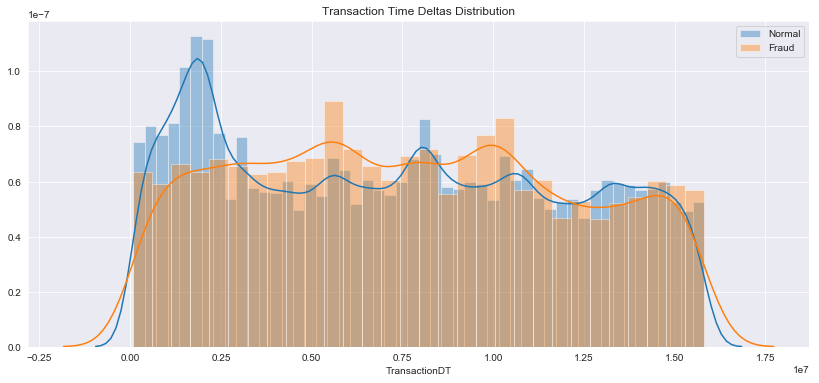

In [11]:
# Plot transaction time delta.
plt.figure(figsize = (14,6))

sns.distplot(df_train.loc[df_train['isFraud'] == 0]['TransactionDT'],kde=True)
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['TransactionDT'],kde=True)
plt.title('Transaction Time Deltas Distribution')
plt.legend(['Normal','Fraud'])
plt.show()

In [12]:
# Test whether group differences are significant.
ttest_ind(df_train[df_train.isFraud == 0][['TransactionDT']],
          df_train[df_train.isFraud == 1][['TransactionDT']])

Ttest_indResult(statistic=array([-10.07009977]), pvalue=array([7.52352445e-24]))

There is a difference in time deltas between normal and fraudulent transactions.

### Transaction Amount
Transaction amount is "transaction payment amount in USD." 

Text(0.5, 1.0, 'Average Transactions Labeled as Normal vs Fraud')

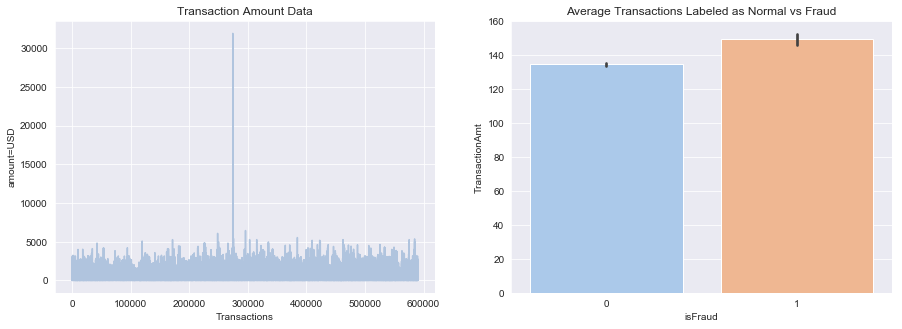

In [13]:
plt.figure(figsize=(15,5))

# Plot transaction amount data.
plt.subplot(1,2,1)
plt.plot(df_train['TransactionAmt'], color='lightsteelblue')
plt.title('Transaction Amount Data')
plt.ylabel('amount=USD')
plt.xlabel('Transactions')

# Plot normal vs. fraudulent transactions.
plt.subplot(1,2,2)
sns.barplot(df_train['isFraud'], df_train['TransactionAmt'],palette='pastel')
plt.title('Average Transactions Labeled as Normal vs Fraud')

In [14]:
# Get mean transaction amount for normal and fraudulent transactions.
df_train[['TransactionAmt','isFraud']].groupby('isFraud').mean()

,TransactionAmt
isFraud,
0,134.511665
1,149.244779


In [15]:
# Test whether group differences are significant.
ttest_ind(df_train[df_train.isFraud == 0][['TransactionAmt']],
          df_train[df_train.isFraud == 1][['TransactionAmt']])

Ttest_indResult(statistic=array([-8.6994436]), pvalue=array([3.34346246e-18]))

In [16]:
# Review transactions over $7,500.
df_train.loc[df_train['TransactionAmt'] > 7500]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
274336,3261336,0,6652360,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing
274339,3261339,0,6652391,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,missing,NaN,missing,missing,missing,missing,missing,missing,missing,missing


The distribution plot shows outliers, which are two transactions for \\$31937.391 not labeled as a fraud. I'll limit the value of outliers and use Tukey's method to confirm there are no other outliers.

Average transaction labeled as fraud is higher than average normal transaction (\\$149.2 vs \\$134.5). T-test confirms that the difference is statistically significant. 

The score threshold is: 1.0
Number of outliers is: 91539
The score threshold is: 1.5
Number of outliers is: 66482
The score threshold is: 2.0
Number of outliers is: 55384
The score threshold is: 2.5
Number of outliers is: 45084
The score threshold is: 3.0
Number of outliers is: 36422
The score threshold is: 3.5
Number of outliers is: 32455
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


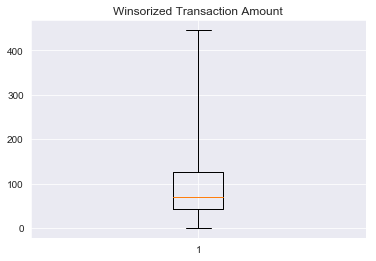

In [17]:
# Limit the value of outliers.
df_train['TransactionAmt'] = winsorize(df_train['TransactionAmt'], (0, 0.05))

# Plot to review if there are outliers.
plt.boxplot(df_train['TransactionAmt'], whis=10)
plt.title('Winsorized Transaction Amount')

# Use Tukey's method to confirm there are no outliers.
q75, q25 = np.percentile(df_train['TransactionAmt'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print('The score threshold is: {}'.format(threshold))
    print('Number of outliers is: {}'.format(
        len((np.where((df_train['TransactionAmt'] > max_val) 
                      | (df_train['TransactionAmt'] < min_val))[0]))
    ))

### Product Code
ProductCD is "product code, the product for each transaction." There are five categories. The meaning of each category is not provided, but there are differences among categories for fraudulent and normal transactions.

ProductCD      C      H      R      S       W
isFraud                                      
0          60511  31450  36273  10942  430701
1           8008   1574   1426    686    8969


Text(0.5, 1.0, 'Normal vs Fraud per Product Code')

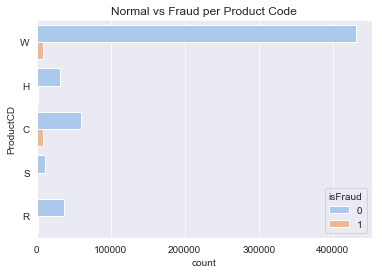

In [18]:
# Review number of normal vs fraudulent transaction based on product code.
count_table = pd.crosstab(df_train['isFraud'], df_train['ProductCD'])
print(count_table)

# Plot counts.
sns.countplot(y=df_train['ProductCD'], hue=df_train['isFraud'], palette='pastel')
plt.title('Normal vs Fraud per Product Code')

In [19]:
# Test if the differences are statistically significant.
print(stats.chisquare(count_table, axis=None))

Power_divergenceResult(statistic=2656302.643817523, pvalue=0.0)


## Payment Card Information

Variables card1 through card6 are "payment card information, such as card type, card category, issue bank, country, etc." It is stated in the data description that these are categorical variables, so I'll impute missing values using most frequent values in each variable. 

In [20]:
# Review missing values.
for i in df_train.columns:
    if i.startswith('card'):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

card1
0.0
card2
1.5126833068039423
card3
0.26501168422122123
card4
0.0
card5
0.7212043214684865
card6
0.0


In [21]:
# Impute data using mode().
for i in df_train.columns:
    if i.startswith('card'):
        df_train[i].fillna(df_train[i].mode()[0], inplace=True)

There is not much insight into what each variable means. I'll plot the distribution of each to have a quick look at differences in distribution.

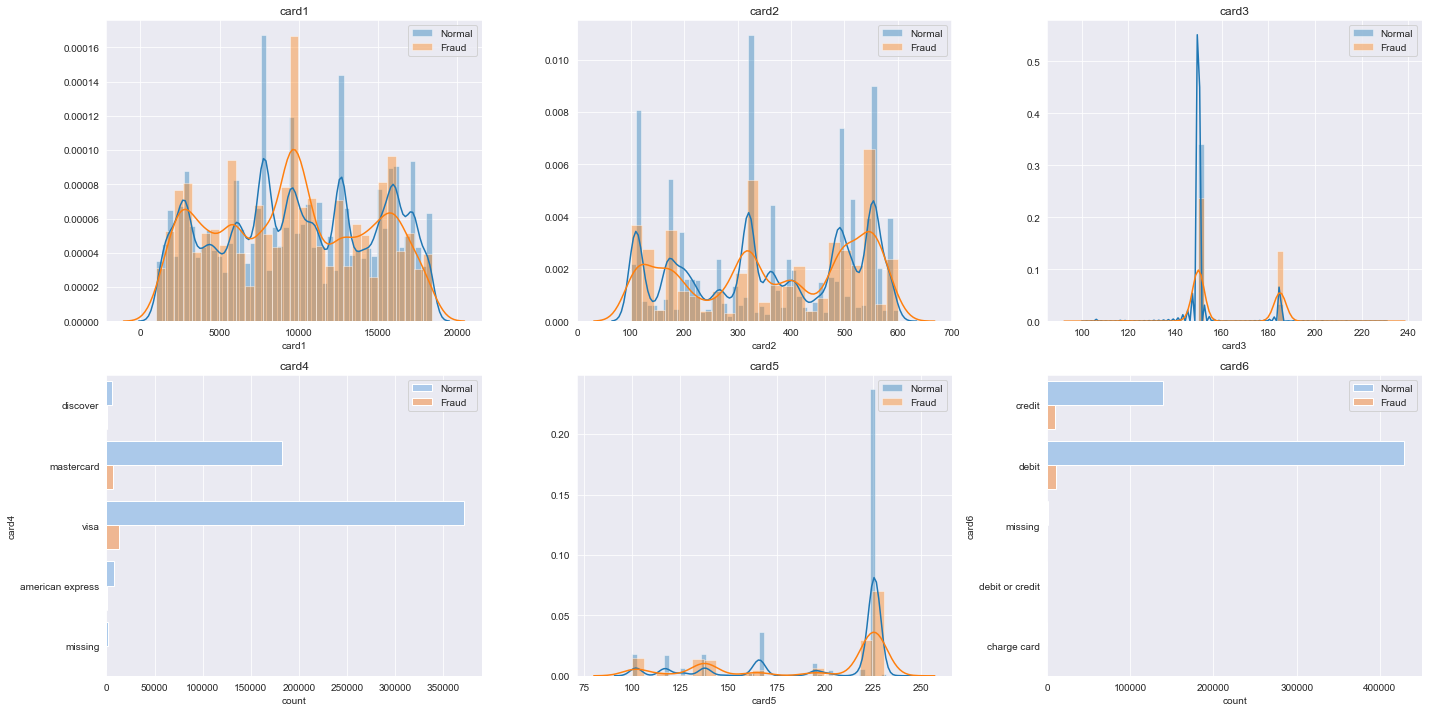

In [22]:
# Plot the variables.
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card1'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card1'])
plt.legend(['Normal','Fraud'])
plt.title('card1')

plt.subplot(2,3,2)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card2'],kde=True)
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card2'],kde=True)
plt.legend(['Normal','Fraud'])
plt.title('card2')

plt.subplot(2,3,3)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card3'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card3'],kde=True)
plt.legend(['Normal','Fraud'])
plt.title('card3')

plt.subplot(2,3,4)
sns.countplot(y=df_train['card4'], hue=df_train['isFraud'], palette='pastel')
plt.legend(['Normal','Fraud'])
plt.title('card4')

plt.subplot(2,3,5)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['card5'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['card5'],kde=True)
plt.legend(['Normal','Fraud'])
plt.title('card5')

plt.subplot(2,3,6)
sns.countplot(y=df_train['card6'], hue=df_train['isFraud'], palette='pastel')
plt.legend(['Normal','Fraud'])
plt.title('card6')
plt.tight_layout()

## Address

Address variables have about 11% of missing data that I'll impute using mode. Data description states that these are also categorical variables, and there is not much insight into what the numbers mean.

In [23]:
# Review missing values.
for i in df_train.columns:
    if i.startswith('addr'):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

addr1
11.12642666034477
addr2
11.12642666034477


In [24]:
# Impute data by mode given that these are categorical variables.
for i in df_train.columns:
    if i.startswith('addr'):
        df_train[i].fillna(df_train[i].mode()[0], inplace=True)

Text(0.5, 1.0, 'addr2')

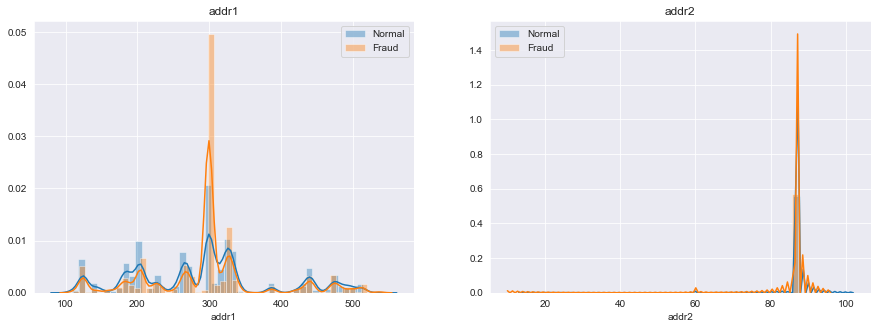

In [25]:
# Plot variables. 
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['addr1'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['addr1'])
plt.title('addr1')
plt.legend(['Normal','Fraud'])

plt.subplot(1,2,2)
sns.distplot(df_train.loc[df_train['isFraud'] == 0]['addr2'])
sns.distplot(df_train.loc[df_train['isFraud'] == 1]['addr2'])
plt.legend(['Normal','Fraud'])
plt.title('addr2')

## Distance
dist1 is a  continuous variable with almost 60% of missing values. It has a lot of unique values, so I'll keep the variable and impute missing data using mean.

In [26]:
# Review dist variables.
for i in df_train.columns:
    if i.startswith('dist'):
        #print(i)
        print('Unique values in column {} are: {}'
          .format(i, df_train[i].unique()))

Unique values in column dist1 are: [  19.   nan  287. ... 4851. 2042. 4728.]
Unique values in column dist2 are: [  nan   30.   98. ... 1467. 1172. 2296.]


In [27]:
# Get percentage of missing values.
df_train['dist1'].isnull().sum()*100/df_train['dist1'].isnull().count()

59.6523520845328

In [28]:
# Impute missing values.
df_train['dist1'].fillna(df_train['dist1'].mean(), inplace=True)

# t-test:
df_train[['dist1','isFraud']].groupby('isFraud').mean()
ttest_ind(df_train[df_train.isFraud == 0][['dist1']],
          df_train[df_train.isFraud == 1][['dist1']])

Ttest_indResult(statistic=array([-7.99592431]), pvalue=array([1.28835029e-15]))

Text(0.5, 1.0, 'Distance')

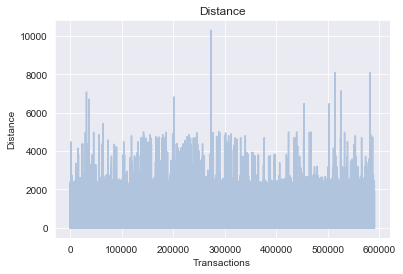

In [29]:
# Plot the distribution of the variable.
plt.plot(df_train['dist1'], color='lightsteelblue')
plt.xlabel('Transactions')
plt.ylabel('Distance')
plt.title('Distance')

### Email domains

P_emaildomain is "purchaser email domain." This variable has many categories with uncommon email domains. I'll engineer a new feature with top email domains and everything else in the "other" category.

['missing' 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com'
 'anonymous.com' 'hotmail.com' 'verizon.net' 'aol.com' 'me.com'
 'comcast.net' 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com'
 'prodigy.net.mx' 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail'
 'live.com' 'att.net' 'juno.com' 'ymail.com' 'sbcglobal.net'
 'bellsouth.net' 'msn.com' 'q.com' 'yahoo.com.mx' 'centurylink.net'
 'servicios-ta.com' 'earthlink.net' 'hotmail.es' 'cfl.rr.com'
 'roadrunner.com' 'netzero.net' 'gmx.de' 'suddenlink.net'
 'frontiernet.net' 'windstream.net' 'frontier.com' 'outlook.es' 'mac.com'
 'netzero.com' 'aim.com' 'web.de' 'twc.com' 'cableone.net' 'yahoo.fr'
 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net' 'live.fr' 'yahoo.co.uk'
 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk' 'protonmail.com' 'yahoo.co.jp']


Text(0.5, 1.0, 'Purchaser Email Domains')

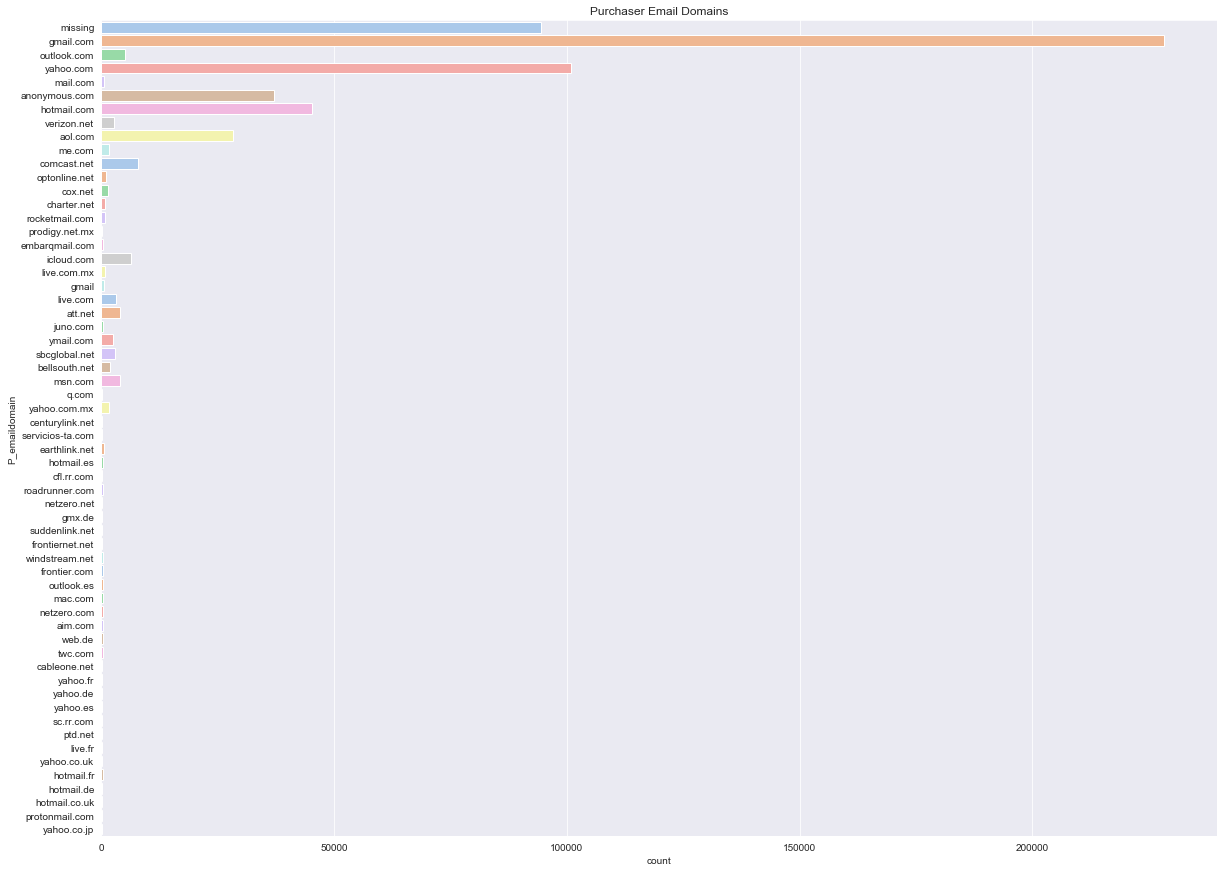

In [30]:
# Review unique values.
print(df_train['P_emaildomain'].unique())

# Plot the counts of values.
plt.figure(figsize=(20,15))
sns.countplot(y=df_train['P_emaildomain'], palette='pastel')
plt.title('Purchaser Email Domains')

Power_divergenceResult(statistic=array([229066.4913534 ,  15408.58563616]), pvalue=array([0., 0.]))


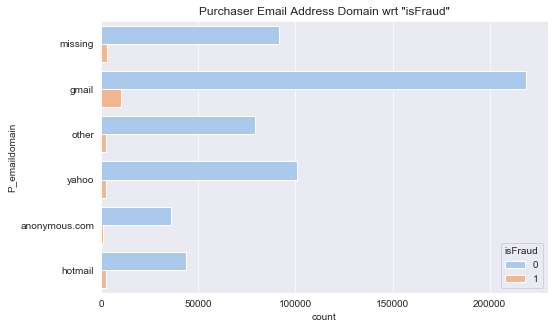

In [31]:
# Engineer new feature.
# De-dupe values such as gmail.com and gmail.
df_train['P_emaildomain']= df_train['P_emaildomain'].replace(
    regex='gmail.*',value='gmail').replace(
    regex='yahoo.*',value='yahoo').replace(
    regex='hotmail.*',value='hotmail')

# Create "other" category.
df_train.loc[~df_train.P_emaildomain.isin(
    ['gmail','yahoo','missing','hotmail','anonymous.com'])
             ,'P_emaildomain'] = 'other'

# Plot the new variable.
plt.figure(figsize=(8,5))
sns.countplot(y=df_train['P_emaildomain'], hue=df_train['isFraud'], palette='pastel')
plt.title('Purchaser Email Address Domain wrt "isFraud"')

# Test group differences.
count_table = pd.crosstab(df_train['P_emaildomain'], df_train['isFraud'])
count_table
print(stats.chisquare(count_table))

**R_emaildomain** is "recipient email domain." It has similar unique values and about 75% of missing values. 

Power_divergenceResult(statistic=array([1546743.66430124,   20541.76261917]), pvalue=array([0., 0.]))


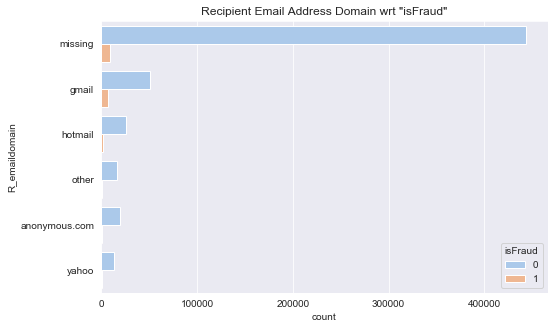

In [32]:
# Engineer new feature.
# De-dupe values such as gmail.com and gmail.
df_train['R_emaildomain']= df_train['R_emaildomain'].replace(
    regex='gmail.*',value='gmail').replace(
    regex='yahoo.*',value='yahoo').replace(
    regex='hotmail.*',value='hotmail')

# Create "other" category.
df_train.loc[~df_train.R_emaildomain.isin(
    ['gmail','yahoo','missing','hotmail','anonymous.com'])
             ,'R_emaildomain'] = 'other'

# Plot the new variable.
plt.figure(figsize=(8,5))
sns.countplot(y=df_train['R_emaildomain'], hue=df_train['isFraud'], palette='pastel')
plt.title('Recipient Email Address Domain wrt "isFraud"')

# Test group differences.
count_table = pd.crosstab(df_train['R_emaildomain'], df_train['isFraud'])
count_table
print(stats.chisquare(count_table))

## Vesta engineered features
Cxxx, Dxxx, Mxxx, and Vxxx are Vesta-engineered features. Given that the actual meaning is masked, it's unclear how to further engineer these features. I'll impute missing values and reduce the dimensionality of some of these features.

### C1-C14
"counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked."

In [33]:
# Review missing and unique values.
for i in df_train.columns:
    if re.findall(r'^C\d', i):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
# #         print('Unique values in column {} are: {}'
# #           .format(i, df_train[i].unique()))

C1
0.0
C2
0.0
C3
0.0
C4
0.0
C5
0.0
C6
0.0
C7
0.0
C8
0.0
C9
0.0
C10
0.0
C11
0.0
C12
0.0
C13
0.0
C14
0.0


Text(0.5, 1.0, 'Correlation of C Features')

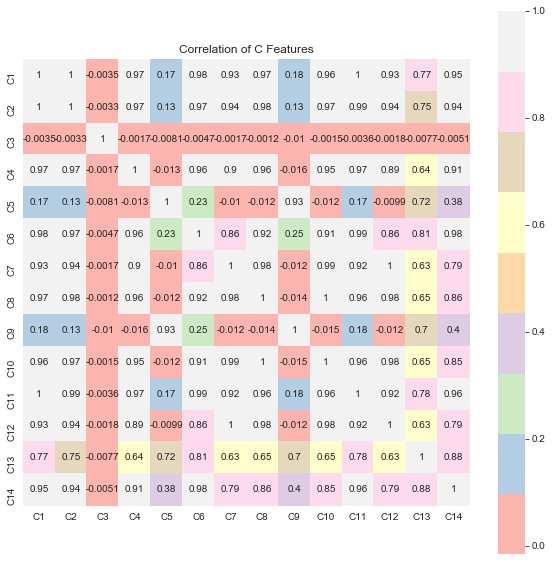

In [34]:
# Review correlation.
plt.figure(figsize=(10,10))

c_check_corr = df_train.filter(regex=('^C\d')).corr()
sns.heatmap(c_check_corr, annot=True, square=True, cmap='Pastel1')
plt.title('Correlation of C Features')

C1-C14 are continuous variables, there are no missing values. Many of these are correlated, which may affect feature importance in tree models.

### D1-D15

"timedelta, such as days between previous transaction, etc."

In [35]:
# Review missing values.
for i in df_train.columns:
    if re.findall(r'^D\d', i):
        print(i)
        print(df_train[i].isnull().sum()*100/df_train[i].isnull().count())
#         print('Unique values in column {} are: {}'
#           .format(i, df_train[i].unique()))

D1
0.21488806854743117
D2
47.54919226470688
D3
44.514850814508755
D4
28.604666915026925
D5
52.46740271615809
D6
87.60676668811597
D7
93.40992989467267
D8
87.31229044603245
D9
87.31229044603245
D10
12.873302401192129
D11
47.29349409015477
D12
89.04104717715988
D13
89.50926270870728
D14
89.46946862193924
D15
15.090087038981272


In [36]:
# Impute missing values by getting mean values.
for i in df_train.columns:
    if re.findall(r'^D\d', i):
        df_train[i].fillna(df_train[i].mean(), inplace=True)

Text(0.5, 1.0, 'Correlation of D Features')

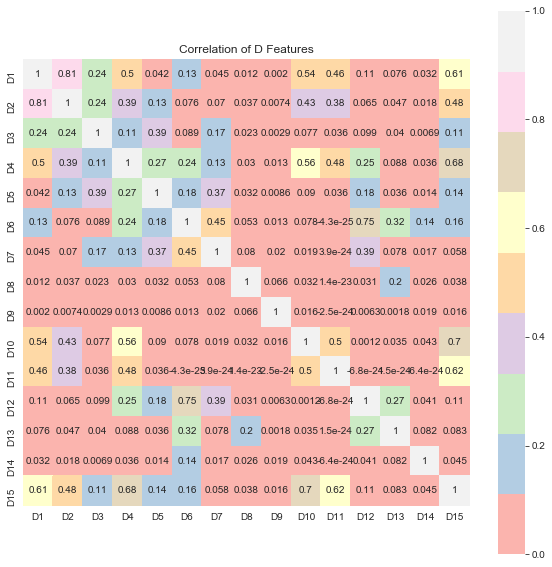

In [37]:
# Review correlation.
d_df = df_train.filter(regex=('^D\d'))

plt.figure(figsize=(10,10))
D_check_corr = d_df.corr()
sns.heatmap(D_check_corr, annot=True, square=True,cmap='Pastel1')
plt.title('Correlation of D Features')

### M1-M9
"match, such as names on card and address, etc." I imputed missing values, but originally some of these variables had almost 50% of missing values.

In [38]:
# Review the variables.
for i in df_train.columns:
    if re.findall(r'^M\d', i):
       # print(i)        
        print('Unique values in column {} are: {}'
          .format(i, df_train[i].unique()))

Unique values in column M1 are: ['T' 'missing' 'F']
Unique values in column M2 are: ['T' 'missing' 'F']
Unique values in column M3 are: ['T' 'missing' 'F']
Unique values in column M4 are: ['M2' 'M0' 'missing' 'M1']
Unique values in column M5 are: ['F' 'T' 'missing']
Unique values in column M6 are: ['T' 'F' 'missing']
Unique values in column M7 are: ['missing' 'F' 'T']
Unique values in column M8 are: ['missing' 'F' 'T']
Unique values in column M9 are: ['missing' 'F' 'T']


### Vxxx

"Vesta engineered rich features, including ranking, counting, and other entity relations." 

I am working with 339 engineered features with no insight into what these variables are. I'll perform principal component analysis (PCA) to reduce dimensionality with the understanding that this may influence the behavior of the models.

In [39]:
# Review "V" features.
v_df = df_train.filter(regex=('^V\d'))
print(v_df.shape)

# Fill missing values with mean.
for i in v_df.columns:
    v_df[i].fillna(v_df[i].mean(),inplace=True)

(590540, 339)


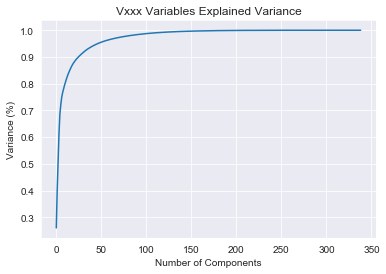

In [40]:
# Standardize data.
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(v_df)
pca = PCA().fit(data_rescaled)

# Plot explained variance.
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Vxxx Variables Explained Variance')
plt.show()

Instead of using 339 variables, I chose to use 25 that explain about 90% of the variance.

In [41]:
# Perform PCA, add new features to the data frame.
pca = PCA(n_components=25)
C_pca = pca.fit_transform(data_rescaled)
principalDf = pd.DataFrame(data = C_pca)

df_train = pd.concat([df_train, principalDf], axis = 1)
df_train = df_train.drop(df_train.filter(regex=('^V\d')),axis=1)

In [42]:
del v_df,principalDf

### DeviceType, DeviceInfo and id

Variables in the identity file are "identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners."

Most of these variables have a lot of missing values. I'll impute data using mean.

In [43]:
# Impute remaining missing values, label encode categorical variables.
encode = LabelEncoder()

for i in df_train.columns:
    if df_train[i].dtype==object:
        df_train[i] = encode.fit_transform(df_train[i])
    else:
        df_train[i].fillna(df_train[i].mean(), inplace=True)

In [44]:
# Review the final dataframe.
# # verify there are no mo missing values:
# df_train.isnull().sum()*100/df_train.isnull().count()

# Verify there are only numeric variables.
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 120 entries, TransactionID to 24
dtypes: float64(85), int64(35)
memory usage: 565.2 MB
None


In [45]:
# Export data to a csv file.
df_train.to_csv('clean_data.csv')

In [46]:
df_train = df_train.drop('TransactionID', axis=1)

## Modeling

In [2]:
df_train = pd.read_csv('clean_data.csv')
df_train = df_train.drop(['Unnamed: 0','TransactionID'], axis=1)
df_train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,15,16,17,18,19,20,21,22,23,24
0,0,86400,68.5,4,13926,321.0,150.0,1,142.0,1,...,0.000689,-0.029924,-0.005267,0.053494,0.118219,-0.022253,-0.017398,0.023684,0.044845,0.006568
1,0,86401,29.0,4,2755,404.0,150.0,2,102.0,1,...,-0.010709,-0.008568,0.001352,0.007927,0.021396,-0.006843,-0.001704,0.011484,0.001272,-0.011197
2,0,86469,59.0,4,4663,490.0,150.0,4,166.0,2,...,-0.014289,0.009391,-0.010364,-0.013300,0.002441,-0.013582,-0.004429,0.015935,-0.006582,-0.000841
3,0,86499,50.0,4,18132,567.0,150.0,2,117.0,2,...,0.173049,0.016494,0.003303,-0.058948,0.013245,0.042591,-0.001904,0.004132,0.031167,0.037969
4,0,86506,50.0,1,4497,514.0,150.0,2,102.0,1,...,-0.005933,-0.001280,-0.011187,0.014176,-0.003686,-0.027814,0.249828,0.007243,0.047629,0.028029


In [3]:
# Keep original dataframe for SMOTE.
df_train_smote = df_train.copy()

### Train/Test Split

In [4]:
# Split data into train and test sets.
y_train=df_train['isFraud']
X_train,X_test,y_train,y_test=train_test_split(df_train.drop('isFraud',axis=1),
                                               y_train,
                                               test_size=.2,
                                               random_state=1,
                                               stratify=y_train)

print('The number of observations in training set is {}'.format(X_train.shape[0]))
print('The number of observations in test set is {}'.format(X_test.shape[0]))

The number of observations in training set is 472432
The number of observations in test set is 118108


## Class Imbalance

To address the class imbalance problem, I'll use Random Undersampling in the train set to randomly select samples from the majority class to even it out with the minority class. I'll also train a model after performing the Synthetic Minority Oversampling Technique (SMOTE), where I'll synthetically create samples of the minority class to even it out with the majority class.

### Random Undersampling

In [5]:
# Randomly under sample the majority class.
print('Original dataset shape %s' % Counter(y_train))

rus = RandomUnderSampler(random_state=1)
X_train, y_train = rus.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 455902, 1: 16530})
Resampled dataset shape Counter({0: 16530, 1: 16530})


## Evaluation Metrics
The goal of the project is to predict the probability that a transaction is fraudulent. The evaluation metric is:

- Area under Receiver Operating Characteristic (ROC AUC), which tells us how much the model is capable of distinguishing between the classes. 

I'll plot the ROC curve with True Positive Rate against the False Positive Rate.

I'll also review:

- classification report to review precision and recall for the minority class
- confusion matrix to review Type I and Type II errors

In [6]:
def evaluate(model):
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_train_proba = model.predict_proba(X_train)[:,1]
    y_pred_test_proba = model.predict_proba(X_test)[:,1]   
    
    # ROC curve
    fpr1, tpr1, _ = metrics.roc_curve(y_train, y_pred_train_proba)
    auc1 = metrics.roc_auc_score(y_train, y_pred_train_proba)

    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_test_proba)

    print('Train ROC AUC:',auc1)
    print('Test ROC AUC:',auc)

    fig, ax = plt.subplots()
    ax.plot(fpr1, tpr1, label='roc_auc_train='+str(auc1))
    ax.plot(fpr, tpr, label='roc_auc_test='+str(auc))

    plt.legend(loc=4)
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print('Test Classification Report:')
    print(metrics.classification_report(y_test, y_pred_test))
    print('-----------------------------------------------')
    
    print('Test Confusion Matrix:')
    print(metrics.confusion_matrix(y_test, y_pred_test))

    table_test = pd.crosstab(y_test, y_pred_test, margins=True)
    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    print('----------------------------------------------')
    
    print((
        'Test Percent Type I errors: {}\n'
        'Test Percent Type II errors: {}'
    ).format(test_tI_errors, test_tII_errors))
    print('---------------------------------------------')

## Logistic Regression

I'll use logistic regression as a **baseline model**. The model predicts the probability of a transaction being fraudulent: if P>0.5, it labels the transaction "1", if P<0.5, it labels the transaction "0". The default threshold in scikit-learn is P>0.5.

Given that I have many features, I'll use **L1 regularization** that shrinks the coefficients of less important variables towards zero.

(Note: I label-encoded categorical variables, which is ok for tree-based models, but can influence the weight of features for logistic regression).

Train ROC AUC: 0.8491011191955524
Test ROC AUC: 0.8491300791775037


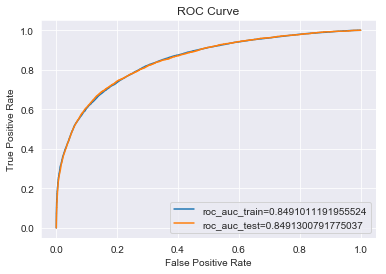

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    113975
           1       0.11      0.75      0.20      4133

    accuracy                           0.79    118108
   macro avg       0.55      0.77      0.54    118108
weighted avg       0.96      0.79      0.85    118108

-----------------------------------------------
Test Confusion Matrix:
[[90027 23948]
 [ 1031  3102]]
----------------------------------------------
Test Percent Type I errors: 0.20276357232363598
Test Percent Type II errors: 0.008729298608053646
---------------------------------------------


In [7]:
# Train a logistic regression model with L1 penalty.
logreg = LogisticRegression(C=1, penalty='l1') # C=1 by default
logreg.fit(X_train,y_train)

evaluate(logreg)

There is 85% chance that this model will be able to distinguish between fraudulent and normal transactions.

## Decision Tree

I'll now train a decision tree model, which learns decision rules from the training data trying to understand why a transaction is labeled as "fraud". It looks at the different attributes in the data, uses them to split the data into subsets, and if some subset is pure, it stops; otherwise, it keeps going. To make a prediction for the new data, it looks at which subset the new sample falls into and uses the dominant class in that subset.

Train ROC AUC: 1.0
Test ROC AUC: 0.7804265795550841


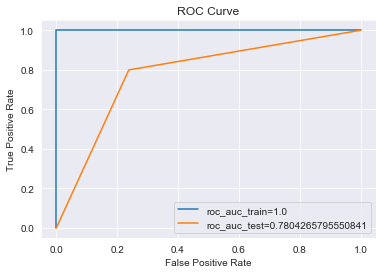

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86    113975
           1       0.11      0.80      0.19      4133

    accuracy                           0.76    118108
   macro avg       0.55      0.78      0.53    118108
weighted avg       0.96      0.76      0.84    118108

-----------------------------------------------
Test Confusion Matrix:
[[86812 27163]
 [  830  3303]]
----------------------------------------------
Test Percent Type I errors: 0.22998442103837166
Test Percent Type II errors: 0.0070274663866969215
---------------------------------------------


In [8]:
# Train a decision tree model with default parameters.
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

# Evaluate.
evaluate(dt)

In [9]:
# Review the hyperparameters of the model.
pprint(dt.get_params())

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}


The model performs worse and it is **overfitting** - it is too specific to the training data and doesn't generalize well. One of the ways to address this is to prune the tree.

### Hyperparameter tuning

I'll use GridSearchCV to tune the following hyperparameters:

- max_leaf_nodes: total number of terminal nodes in a tree
- min_samples_leaf: minimum number of samples required to be at a leaf node
- max_depth: how deep the tree can be (the deeper the tree, the more splits it has and captures more information about the data)
- criterion: function to measure the quality of a split point for root nodes

In [7]:
decision_tree = DecisionTreeClassifier()

param_grid = {
    'max_leaf_nodes': [2, 10, 20],
    'min_samples_leaf':[1, 5],
    'max_depth': [1, 5],
    'criterion':['gini','entropy']
}

grid_search = GridSearchCV(estimator = decision_tree, param_grid = param_grid, 
                           scoring = 'roc_auc', n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   14.8s finished


{'criterion': 'gini',
 'max_depth': 5,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 1}

Train ROC AUC: 0.8366296023033154
Test ROC AUC: 0.8337892981166305


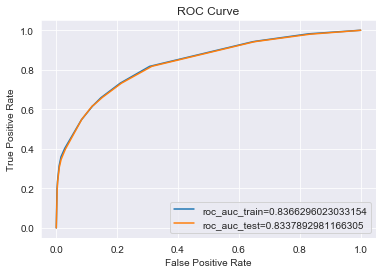

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88    113975
           1       0.11      0.73      0.19      4133

    accuracy                           0.78    118108
   macro avg       0.55      0.76      0.53    118108
weighted avg       0.96      0.78      0.85    118108

-----------------------------------------------
Test Confusion Matrix:
[[89609 24366]
 [ 1108  3025]]
----------------------------------------------
Test Percent Type I errors: 0.20630270599790024
Test Percent Type II errors: 0.009381244284891795
---------------------------------------------


In [8]:
# Re-train the model.
dt1 = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    max_leaf_nodes=20,
    min_samples_leaf=1,
    random_state = 1
)
dt1.fit(X_train,y_train)

# Evaluate.
evaluate(dt1)

I was able to address overfitting. The score is below the baseline score. (ROC AUC = 0.833 vs 0.849).

In [9]:
features = df_train.drop('isFraud', axis=1).columns

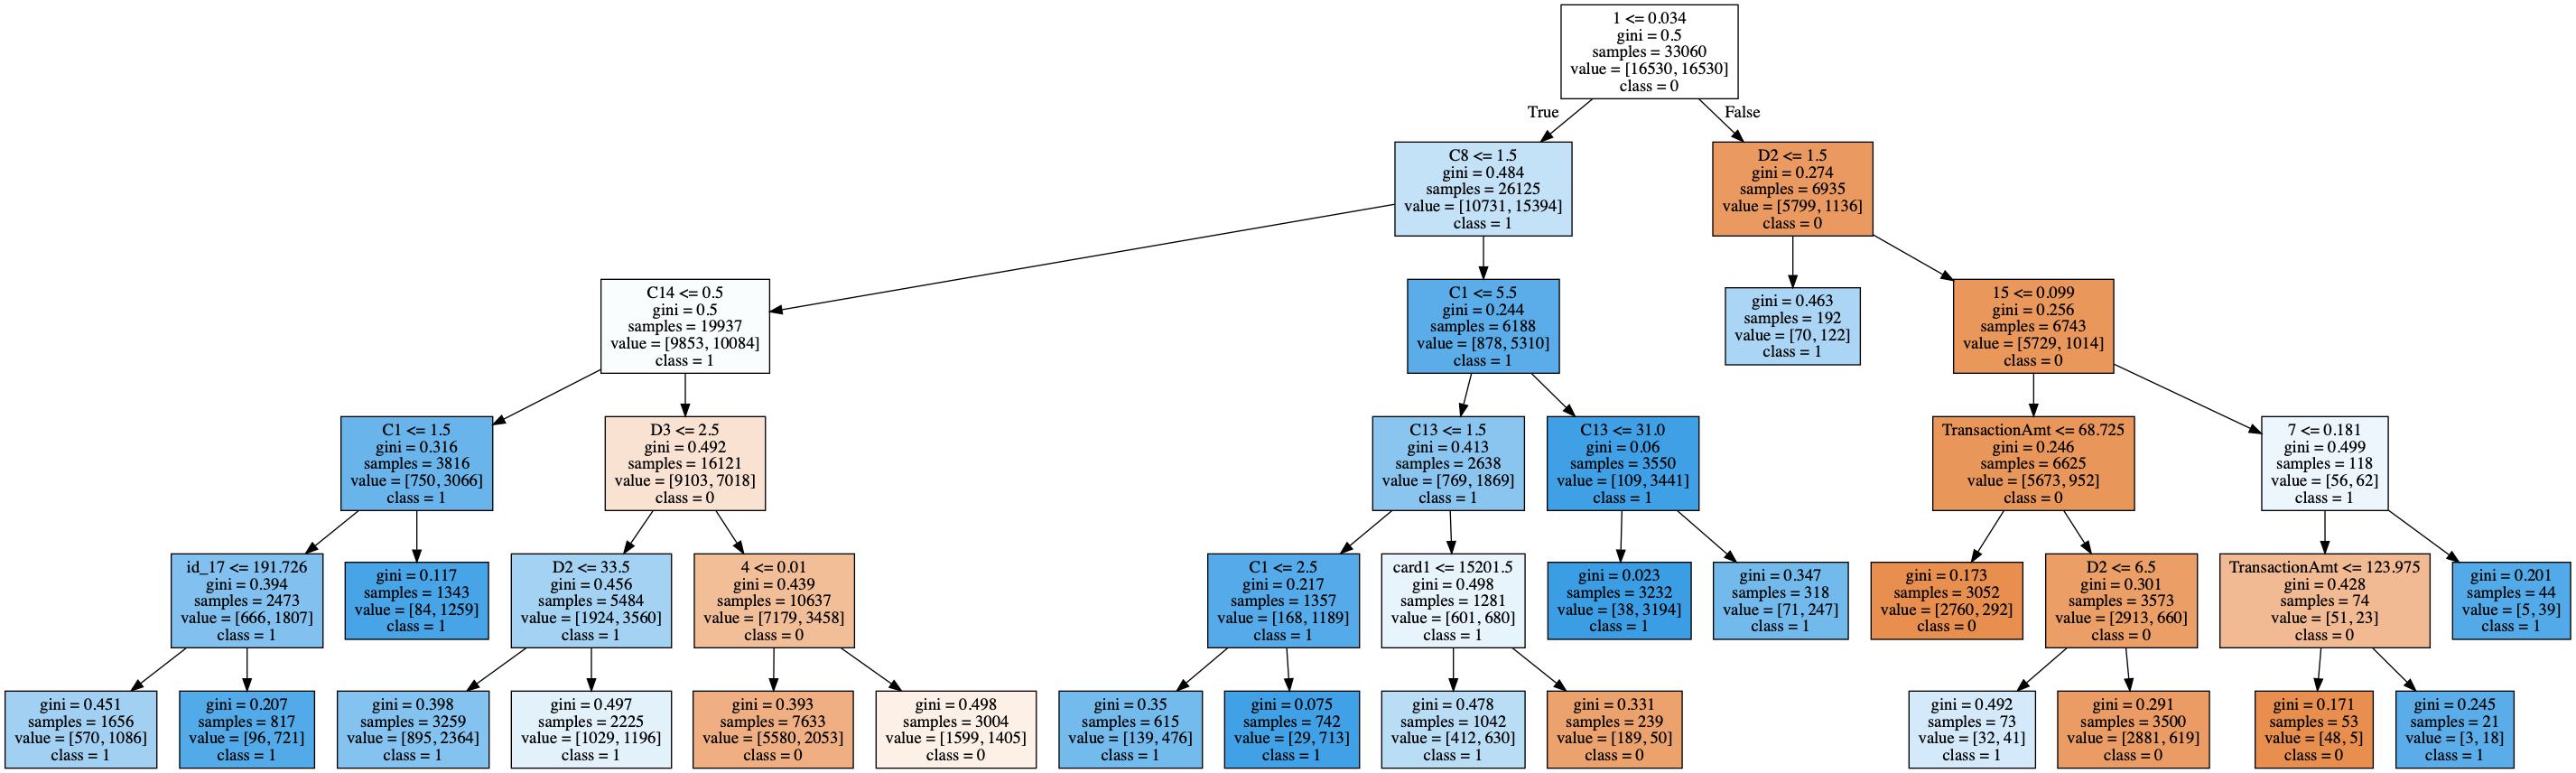

In [10]:
# Plot the tree.
dot_data = tree.export_graphviz(
    dt1, out_file=None,
    feature_names=features,
    class_names=['0', '1'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Gradient Boosting Classifier

Next, I'll train ensemble models that train several models to make predictions. I'll start with a gradient boosting classifier that builds decision trees in a sequential manner. The default number of decision trees is 100.

Train ROC AUC: 0.9015696295832725
Test ROC AUC: 0.8904837831507932


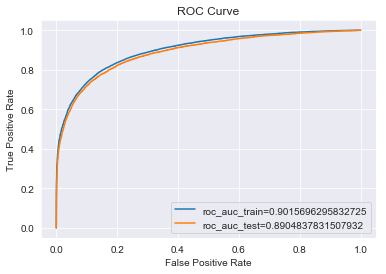

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91    113975
           1       0.15      0.79      0.25      4133

    accuracy                           0.84    118108
   macro avg       0.57      0.81      0.58    118108
weighted avg       0.96      0.84      0.88    118108

-----------------------------------------------
Test Confusion Matrix:
[[95384 18591]
 [  870  3263]]
----------------------------------------------
Test Percent Type I errors: 0.15740678023503912
Test Percent Type II errors: 0.007366139465573881
---------------------------------------------


In [17]:
# Train a gradient boosting classifier model with default parameters.
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train, y_train)

evaluate(gbc)

The model has the highest score so far.

In [18]:
# Review the parameters of the model.
pprint(gbc.get_params())

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


Train ROC AUC: 0.9777825482934654
Test ROC AUC: 0.9362283180540089


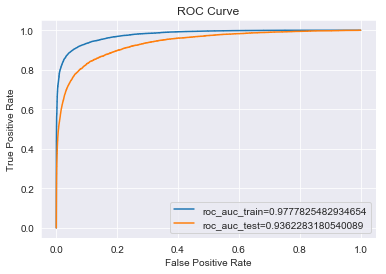

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.94    113975
           1       0.21      0.85      0.33      4133

    accuracy                           0.88    118108
   macro avg       0.60      0.86      0.63    118108
weighted avg       0.97      0.88      0.91    118108

-----------------------------------------------
Test Confusion Matrix:
[[100683  13292]
 [   640   3493]]
----------------------------------------------
Test Percent Type I errors: 0.11254106411081383
Test Percent Type II errors: 0.005418769262031361
---------------------------------------------


In [14]:
# Re-train the model with 500 trees and specified tree-specific parameters.
gbc1 = ensemble.GradientBoostingClassifier(n_estimators=500,
                                           max_depth=5,
                                           max_leaf_nodes=20,
                                           min_samples_leaf=1
                                          )
gbc1.fit(X_train, y_train)

evaluate(gbc1)

The model has the highest score, but also has a 0.041 difference in scores for train and test sets.

In [15]:
# Review important features.
feature_list = list(df_train.drop('isFraud',axis=1).columns)

importances = list(gbc1.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: 1                    Importance: 0.13
Variable: C14                  Importance: 0.08
Variable: C1                   Importance: 0.06
Variable: C8                   Importance: 0.05
Variable: D3                   Importance: 0.05
Variable: TransactionAmt       Importance: 0.04
Variable: D2                   Importance: 0.04
Variable: C11                  Importance: 0.03
Variable: TransactionDT        Importance: 0.02
Variable: card1                Importance: 0.02
Variable: card2                Importance: 0.02
Variable: card6                Importance: 0.02
Variable: C13                  Importance: 0.02
Variable: D8                   Importance: 0.02
Variable: id_17                Importance: 0.02
Variable: 7                    Importance: 0.02
Variable: ProductCD            Importance: 0.01
Variable: card3                Importance: 0.01
Variable: card5                Importance: 0.01
Variable: addr1                Importance: 0.01
Variable: dist1                Importanc

### Hyperparameter tuning

I'll tune the following boosting parameters:
- n_estimators: the number of trees in the forest
- learning_rate: controls the weight of new trees added to the model

As well as max_depth (the maximum number of levels in each tree).

In [19]:
gbc = ensemble.GradientBoostingClassifier()

param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.1, 0.01],
    'max_depth': [2, 4, 8]
}

grid_search = GridSearchCV(estimator = gbc, param_grid = param_grid, 
                          scoring = 'roc_auc', n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 112.2min finished


{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000}

Train ROC AUC: 1.0
Test ROC AUC: 0.9554884983277296


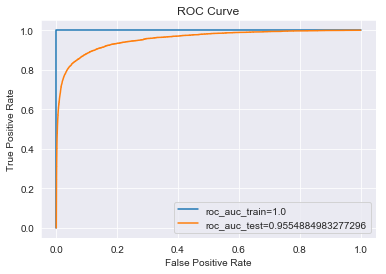

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    113975
           1       0.24      0.88      0.38      4133

    accuracy                           0.90    118108
   macro avg       0.62      0.89      0.66    118108
weighted avg       0.97      0.90      0.93    118108

-----------------------------------------------
Test Confusion Matrix:
[[102562  11413]
 [   488   3645]]
----------------------------------------------
Test Percent Type I errors: 0.09663189623056863
Test Percent Type II errors: 0.004131811562298913
---------------------------------------------


In [26]:
# Re-train the model.
gbc2 = ensemble.GradientBoostingClassifier(n_estimators=1000,
                                         learning_rate=0.1,
                                         max_depth=8)
gbc2.fit(X_train, y_train)

evaluate(gbc2)

The model has better score but it overfits. The next steps would be to include additional tree-specific parameters when optimizing the model.

In [17]:
gbc = ensemble.GradientBoostingClassifier()

param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.1, 0.01],
    'max_depth': [5],
    'max_leaf_nodes': [20],
    'min_samples_leaf': [1]
}


grid_search = GridSearchCV(estimator = gbc, param_grid = param_grid, 
                          scoring = 'roc_auc', n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 37.2min finished


{'learning_rate': 0.1,
 'max_depth': 5,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 1,
 'n_estimators': 1000}

Train ROC AUC: 0.9931660560333391
Test ROC AUC: 0.9446096327596558


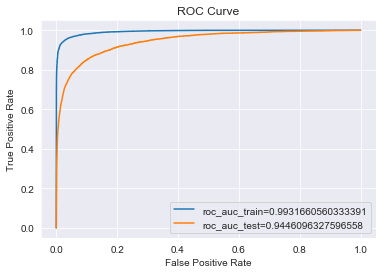

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94    113975
           1       0.22      0.86      0.35      4133

    accuracy                           0.89    118108
   macro avg       0.61      0.88      0.65    118108
weighted avg       0.97      0.89      0.92    118108

-----------------------------------------------
Test Confusion Matrix:
[[101477  12498]
 [   580   3553]]
----------------------------------------------
Test Percent Type I errors: 0.10581840349510617
Test Percent Type II errors: 0.004910759643715921
---------------------------------------------


In [19]:
gbc3 = ensemble.GradientBoostingClassifier(n_estimators=1000,
                                           max_depth=5,
                                           max_leaf_nodes=20,
                                           min_samples_leaf=1
                                          )
gbc3.fit(X_train, y_train)

evaluate(gbc3)

This model has the highest score and a 0.045 difference in test and train scores.

## Random Forest

Next, I'll train a random forest model, which takes a subset of observations and a subset of variables to build decision trees. It makes predictions for the new data by classifying a data point using all those trees and using the majority vote.

Train ROC AUC: 0.9997391075055015
Test ROC AUC: 0.9096071991456266


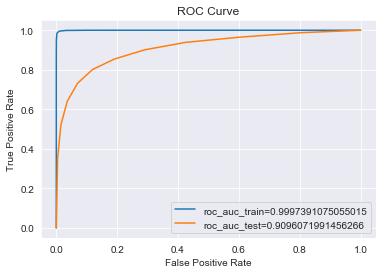

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113975
           1       0.20      0.80      0.31      4133

    accuracy                           0.88    118108
   macro avg       0.59      0.84      0.62    118108
weighted avg       0.96      0.88      0.91    118108

-----------------------------------------------
Test Confusion Matrix:
[[100366  13609]
 [   820   3313]]
----------------------------------------------
Test Percent Type I errors: 0.11522504826091375
Test Percent Type II errors: 0.006942798116977681
---------------------------------------------


In [20]:
# Train a random forest model with default parameters.
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

evaluate(rfc)

In [21]:
# Review the parameters of the model.
pprint(rfc.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Hyperparameter tuning

I'll tune n_estimators, max_depth, min_samples_leaf, along with:
- max_features: how many features each tree is randomly assigned

In [22]:
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_features': ['auto', 4, 10],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 10]
}

grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          scoring = 'roc_auc', n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 24.4min finished


{'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 1,
 'n_estimators': 1000}

Train ROC AUC: 1.0
Test ROC AUC: 0.9315203111374607


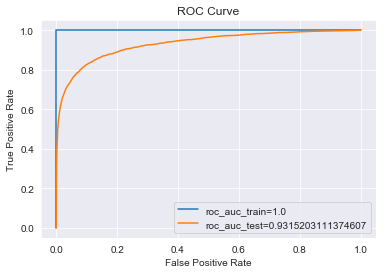

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113975
           1       0.20      0.84      0.33      4133

    accuracy                           0.88    118108
   macro avg       0.60      0.86      0.63    118108
weighted avg       0.97      0.88      0.91    118108

-----------------------------------------------
Test Confusion Matrix:
[[100195  13780]
 [   644   3489]]
----------------------------------------------
Test Percent Type I errors: 0.11667287567311274
Test Percent Type II errors: 0.0054526365699190575
---------------------------------------------


In [28]:
rfc2 = RandomForestClassifier(n_estimators=1000,
                              max_features=10,
                              max_depth=None,
                              min_samples_leaf=1)

rfc2.fit(X_train, y_train)

# Evaluate.
evaluate(rfc2)

This model also overfits. 

I manually tuned the hyperparameters, and the model below has the best performance. The performance is better in terms of overfitting, but the score went down.

Train ROC AUC: 0.922000549698087
Test ROC AUC: 0.8943435836310625


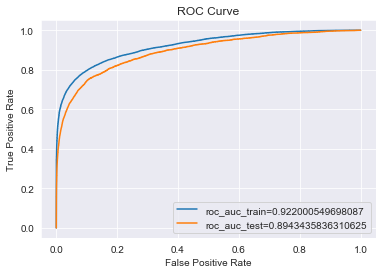

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92    113975
           1       0.16      0.78      0.27      4133

    accuracy                           0.85    118108
   macro avg       0.58      0.82      0.60    118108
weighted avg       0.96      0.85      0.90    118108

-----------------------------------------------
Test Confusion Matrix:
[[97696 16279]
 [  919  3214]]
----------------------------------------------
Test Percent Type I errors: 0.13783147627595083
Test Percent Type II errors: 0.007781013987198157
---------------------------------------------


In [29]:
# Re-train the model to address overfitting.
rfc3 = RandomForestClassifier(n_estimators=500,
                              max_depth=10,
                              max_features=10,
                              min_samples_leaf=5)
rfc3.fit(X_train, y_train)

evaluate(rfc3)

In [44]:
# Review important features.
feature_list = list(df_train.drop('isFraud',axis=1).columns)

importances = list(rfc3.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: 1                    Importance: 0.06
Variable: C14                  Importance: 0.04
Variable: C5                   Importance: 0.03
Variable: C8                   Importance: 0.03
Variable: C13                  Importance: 0.03
Variable: D3                   Importance: 0.03
Variable: 11                   Importance: 0.03
Variable: TransactionAmt       Importance: 0.02
Variable: card6                Importance: 0.02
Variable: C1                   Importance: 0.02
Variable: C2                   Importance: 0.02
Variable: C4                   Importance: 0.02
Variable: C10                  Importance: 0.02
Variable: C11                  Importance: 0.02
Variable: C12                  Importance: 0.02
Variable: D2                   Importance: 0.02
Variable: M4                   Importance: 0.02
Variable: id_17                Importance: 0.02
Variable: 7                    Importance: 0.02
Variable: 17                   Importance: 0.02
Variable: TransactionDT        Importanc

In [22]:
# Try a model with less features.
y_f_train=df_train['isFraud']
X_f_train,X_f_test,y_f_train,y_f_test=train_test_split(df_train[['TransactionDT',
                                                               'TransactionAmt',
                                                               'C13', '1', 'card1',
                                                               'card2', 'addr1',
                                                               'C1', 'C5', 'C14',
                                                               'D2', 'D3', '4', '7',
                                                               '9', '11', '16', '17']],
                                               y_f_train,
                                               test_size=.2,
                                               random_state=42)

print('The number of observations in training set is {}'.format(X_f_train.shape[0]))
print('The number of observations in test set is {}'.format(X_f_test.shape[0]))

# Randomly under sample the majority class.
print('Original dataset shape %s' % Counter(y_f_train))

rus = RandomUnderSampler(random_state=42)
X_f_train, y_f_train = rus.fit_sample(X_f_train, y_f_train)

print('Resampled dataset shape %s' % Counter(y_f_train))

The number of observations in training set is 472432
The number of observations in test set is 118108
Original dataset shape Counter({0: 456011, 1: 16421})
Resampled dataset shape Counter({0: 16421, 1: 16421})


In [23]:
rfc_f = RandomForestClassifier(n_estimators=500,
                               max_features=10,
                               max_depth=5,
                               max_leaf_nodes=20,
                               min_samples_leaf=1)

rfc_f.fit(X_f_train, y_f_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=10, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Train ROC AUC: 0.8514456341451375
Test ROC AUC: 0.8531653164563692


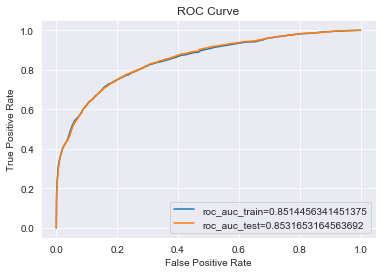

In [24]:
y_f_pred_train = rfc_f.predict(X_f_train)
y_f_pred_test = rfc_f.predict(X_f_test)
y_f_pred_train_proba = rfc_f.predict_proba(X_f_train)[:,1]
y_f_pred_test_proba = rfc_f.predict_proba(X_f_test)[:,1]   

# ROC curve
fpr1, tpr1, _ = metrics.roc_curve(y_f_train, y_f_pred_train_proba)
auc1 = metrics.roc_auc_score(y_f_train, y_f_pred_train_proba)

fpr, tpr, _ = metrics.roc_curve(y_f_test, y_f_pred_test_proba)
auc = metrics.roc_auc_score(y_f_test, y_f_pred_test_proba)

print('Train ROC AUC:',auc1)
print('Test ROC AUC:',auc)

fig, ax = plt.subplots()
ax.plot(fpr1, tpr1, label='roc_auc_train='+str(auc1))
ax.plot(fpr, tpr, label='roc_auc_test='+str(auc))

plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The model doesn't overfit, but the score went down.

### Synthetic Minority Oversampling Technique (SMOTE)
Finally, I'll use SMOTE on the train set to train a gradient boosting classifier.

In [25]:
y_train=df_train_smote['isFraud']
X_train,X_test,y_train,y_test=train_test_split(df_train_smote.drop('isFraud',axis=1),
                                               y_train, test_size=.2, random_state=1,
                                               stratify=y_train)

print('The number of observations in training set is {}'.format(X_train.shape[0]))
print('The number of observations in test set is {}'.format(X_test.shape[0]))

# use SMOTE:
print('Original dataset shape %s' % Counter(y_train))

sm = SMOTE(ratio='minority',random_state=1)
X_train, y_train = sm.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

The number of observations in training set is 472432
The number of observations in test set is 118108
Original dataset shape Counter({0: 455902, 1: 16530})
Resampled dataset shape Counter({0: 455902, 1: 455902})


Train ROC AUC: 0.9972874168119836
Test ROC AUC: 0.9176063427767253


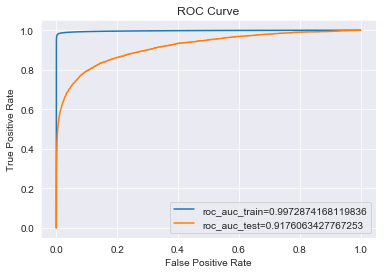

Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.83      0.48      0.60      4133

    accuracy                           0.98    118108
   macro avg       0.90      0.74      0.80    118108
weighted avg       0.98      0.98      0.98    118108

-----------------------------------------------
Test Confusion Matrix:
[[113558    417]
 [  2163   1970]]
----------------------------------------------
Test Percent Type I errors: 0.003530666847292309
Test Percent Type II errors: 0.018313746740271617
---------------------------------------------


In [26]:
gbc_s = ensemble.GradientBoostingClassifier(n_estimators=500,
                                           max_depth=5,
                                           max_leaf_nodes=20,
                                           min_samples_leaf=1
                                          )
gbc_s.fit(X_train, y_train)

evaluate(gbc_s)

The model's performance is worse in terms of ROC AUC, Type II errors and overfitting. It has higher precision than other models.

(Note: there is not enough memory on my computer to perform grid search cross validation model tuning on this data.)

## Summary

The baseline model, logistic regression with L1 regularization parameter, has a ROC AUC score=0.84. A single decision tree did slightly worse, with a score=0.83. The original decision tree model overfitted to data, which I addressed by pruning the tree.

Ensemble models did the best in terms of ROC AUC score: gradient boosting classifiers scored 0.94 and a random forest model scored 0.89. The biggest challenge was making sure that the models generalize well, which can be further improved given that the difference in scores between the train and validation/test sets for the best model is 0.04. This can be addressed by further tuning the hyperparameters of the models or additional feature engineering/selection. 

In addition, big data technologies could be utilized so that more experimentation can be done with data after synthetic samples were generated to address class imbalance.